# Dose-Response Curves and Logistic Regression

This notebook uses the processed data outputs from the hexosaminidase and LDH assay analysis notebooks to generate dose-response curves. It is useful for experiments that test many doses of a particular pruritogen, and for identifying non-toxic treatment concentrations that can induce degranulation.

### Inputs
The input data for this notebook are processed datafiles (`labeled_datafile_hex` and `labeled_datafile_ldh`) that are outputs of the hexosaminidase and LDH assay analysis notebooks (`hex_assay_analysis_main.ipynb` and `ldh_assay_analysis_main.ipynb`, respectively). The hexosaminidase assay file name has the suffix `_labeled` after the original raw data file name, and the LDH assay file has the suffix `_ldh_concs_filtered`.

Other parameters defined by the user include the names of control samples `positive_control`, `negative_control`, and `ldh_assay_control`, and the hexosaminidase assay standard values `standard_vals_hex`, which are not plotted. The parameter `experiment_name` is used to label plots.

### Outputs
Each input processed data file (hexosaminidase and LDH) produces a plot of the dose response points and a plot of these points with an associated sigmoid fit curve. These are plotted with log<sub>10</sub>(concentration) values on the x-axis and are exported as png files.

To facilitate comparison between assays, the y-values of each dataset and their sigmoid fits are normalized to a relative response between 0 and 1. These transformed results are also plotted and exported as a png file.

The notebook stores outputs for the hexosaminidase and LDH assays in the same output subdirectory as the inputs. The superimposed curve is stored in the hexosamindase output directory.

In [1]:
import os
import re

import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
# Parameterization

labeled_datafile_hex = "../output_files/20250204_hex_assay/20250204_hex_assay_labeled.csv"
labeled_datafile_ldh = (
    "../output_files/20250204_ldh_assay/20250204_ldh_assay_ldh_concs_filtered.csv"
)

positive_control = "Lysed"
negative_control = "PBS"
ldh_assay_control = "LDH Positive Control"

# enter the standard labels as a list of strings.
standard_vals_hex = [
    "500",
    "250",
    "125",
    "0",
]

# enter the name of the experiment as a string for plot labels.
experiment_name = "20250204 48/80 Dose Response Assay in HMC1.2"

In [3]:
if os.path.exists(labeled_datafile_hex):
    labeled_data_hex = pd.read_csv(labeled_datafile_hex)
    print(f"File '{labeled_datafile_hex}' loaded successfully.")
else:
    print(f"Error: File '{labeled_datafile_hex}' not found at the specified location.")
    print(
        """
        Please check the file path, file name, and ensure the file is present
        at the specified location.
        """
    )

labeled_data_hex

File '../output_files/20250204_hex_assay/20250204_hex_assay_labeled.csv' loaded successfully.


,60.6 µg/mL,20.2 µg/mL,6.73 µg/mL,2.24 µg/mL,748 ng/mL,249 ng/mL,83.1 ng/mL,27.7 ng/mL,9.24 ng/mL,Lysed,PBS,500,250,125,0
0,2.602716e+07,2.349805e+07,2.358481e+07,2.297603e+07,2.236934e+07,2.346602e+07,2.259725e+07,2.106819e+07,2.237815e+07,2.914245e+07,2.211027e+07,1.487027e+09,9.919810e+08,4.965023e+08,9.667522e+06
1,2.653273e+07,2.308537e+07,2.289376e+07,2.225071e+07,2.167797e+07,2.146142e+07,2.070416e+07,2.052887e+07,1.933568e+07,2.216882e+07,1.901740e+07,1.504572e+09,9.991414e+08,5.633787e+08,1.127013e+07
2,2.341077e+07,2.117251e+07,1.932511e+07,1.928445e+07,1.981634e+07,1.844763e+07,1.912276e+07,1.899725e+07,1.774887e+07,2.288782e+07,1.879984e+07,1.473287e+09,9.453485e+08,5.497421e+08,4.616409e+06


In [4]:
labeled_data_hex = labeled_data_hex.drop(columns=standard_vals_hex)
labeled_data_hex

,60.6 µg/mL,20.2 µg/mL,6.73 µg/mL,2.24 µg/mL,748 ng/mL,249 ng/mL,83.1 ng/mL,27.7 ng/mL,9.24 ng/mL,Lysed,PBS
0,2.602716e+07,2.349805e+07,2.358481e+07,2.297603e+07,2.236934e+07,2.346602e+07,2.259725e+07,2.106819e+07,2.237815e+07,2.914245e+07,2.211027e+07
1,2.653273e+07,2.308537e+07,2.289376e+07,2.225071e+07,2.167797e+07,2.146142e+07,2.070416e+07,2.052887e+07,1.933568e+07,2.216882e+07,1.901740e+07
2,2.341077e+07,2.117251e+07,1.932511e+07,1.928445e+07,1.981634e+07,1.844763e+07,1.912276e+07,1.899725e+07,1.774887e+07,2.288782e+07,1.879984e+07


In [5]:
# Sample concentrations must be represented as floats to plot a dose-response curve.


def parse_sample_concentrations(sample):
    """
    Parses sample concentrations from strings with µg/mL and ng/mL unit labels into floats in µg/mL.
    Returns None for samples without a unit label.

    Args:
        sample: A sample name, as a string.

    Returns:
        float: The sample concentration in µg/mL.
    """
    match = re.search(r"([\d\.]+)\s*(µg|ng)/mL", sample)
    if match:
        value, unit = float(match.group(1)), match.group(2)
        return value if unit == "µg" else value / 1000
    return None


float_concentration_data_hex = {}

for col in labeled_data_hex.columns:
    concentration = parse_sample_concentrations(col)
    if concentration is not None:
        float_concentration_data_hex[concentration] = labeled_data_hex[col]

float_concentration_df_hex = pd.DataFrame(float_concentration_data_hex)
float_concentration_df_hex

,60.60000,20.20000,6.73000,2.24000,0.74800,0.24900,0.08310,0.02770,0.00924
0,2.602716e+07,2.349805e+07,2.358481e+07,2.297603e+07,2.236934e+07,2.346602e+07,2.259725e+07,2.106819e+07,2.237815e+07
1,2.653273e+07,2.308537e+07,2.289376e+07,2.225071e+07,2.167797e+07,2.146142e+07,2.070416e+07,2.052887e+07,1.933568e+07
2,2.341077e+07,2.117251e+07,1.932511e+07,1.928445e+07,1.981634e+07,1.844763e+07,1.912276e+07,1.899725e+07,1.774887e+07


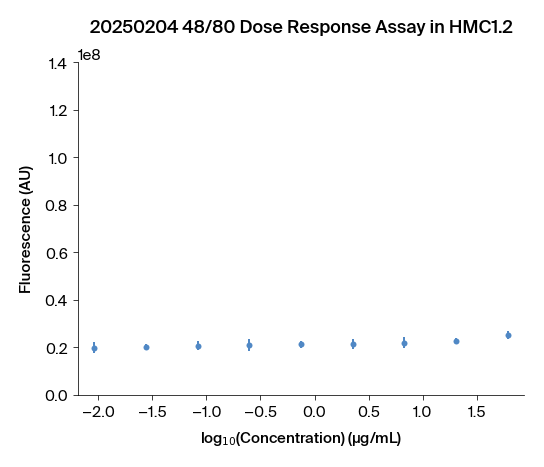

In [6]:
log_concentrations_hex = np.log10(float_concentration_df_hex.columns.astype(float))

means = float_concentration_df_hex.mean()
std_devs = float_concentration_df_hex.std()

apc.mpl.setup()
plt.figure(figsize=(8, 6))
plt.errorbar(log_concentrations_hex, means, yerr=std_devs, fmt="o", capsize=5, label="Data")

plt.xlabel(r"log$_{10}$(Concentration) (µg/mL)")
plt.ylabel("Fluorescence (AU)")
plt.title(experiment_name)

plt.ylim(0, 1.4e8)

plt.savefig(labeled_datafile_hex[:-4] + "_doseresponse.png", transparent=False)
plt.show()

In [7]:
# Logistic fit works best for dose response data with log(concentration).

def sigmoid(x, bottom, top, log_EC50, slope):
    return bottom + (top - bottom) / (1 + np.exp(-slope * (x - log_EC50)))


x_data_hex = log_concentrations_hex
y_data_hex = float_concentration_df_hex.mean().values

p0 = [min(y_data_hex), max(y_data_hex), np.median(x_data_hex), 1]

params_hex, _ = curve_fit(sigmoid, x_data_hex, y_data_hex, p0=p0)
EC50 = 10 ** params_hex[2]

y_pred_hex = sigmoid(x_data_hex, *params_hex)

ss_res = np.sum((y_data_hex - y_pred_hex) ** 2)
ss_tot = np.sum((y_data_hex - np.mean(y_data_hex)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print("Fitted Parameters:")
print(f"  Min: {params_hex[0]:.2e}")
print(f"  Max: {params_hex[1]:.2e}")
print(f"  EC50: {EC50:.3f} µg/mL")
print(f"  Slope: {params_hex[3]:.3f}")
print("Goodness of Fit:")
print(f"  R²: {r_squared:.4f}")

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [8]:
# A smoothed curve is best for plotting.

x_fit_hex = np.linspace(min(x_data_hex), max(x_data_hex), 100)
y_fit_hex = sigmoid(x_fit_hex, *params_hex)

plt.figure(figsize=(8, 6))
plt.errorbar(
    x_data_hex,
    y_data_hex,
    yerr=float_concentration_df_hex.std(),
    fmt="o",
    capsize=5,
    label="Data",
)
plt.plot(x_fit_hex, y_fit_hex, label="Logistic Fit", linestyle="--")

plt.xlabel(r"log$_{10}$(Concentration) (µg/mL)")
plt.ylabel("Fluorescence (AU)")
plt.title(experiment_name)
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.ylim(0, 1.4e8)

plt.savefig(labeled_datafile_hex[:-4] + "_doseresponse_curvefit.png", transparent=False)
plt.show()

NameError: name 'params_hex' is not defined

In [9]:
if os.path.exists(labeled_datafile_ldh):
    labeled_data_ldh = pd.read_csv(labeled_datafile_ldh)
    print(f"File '{labeled_datafile_ldh}' loaded successfully.")
else:
    print(f"Error: File '{labeled_datafile_ldh}' not found at the specified location.")
    print(
        """
        Please check the file path, file name, and ensure the file is present
        at the specified location.
        """
    )

labeled_data_ldh

File '../output_files/20250204_ldh_assay/20250204_ldh_assay_ldh_concs_filtered.csv' loaded successfully.


,Sample,"Abs, t = 0","Abs, t = 480","NADH, t = 0","NADH, t = 480",dilution,LDH
0,60.6 µg/mL,0.192,1.867,52.947274,420.550160,5,4595.036070
1,60.6 µg/mL,0.276,2.195,76.002189,481.329685,5,5066.593700
2,60.6 µg/mL,0.230,2.234,63.394954,488.375613,5,5312.258236
3,20.2 µg/mL,0.058,0.521,15.863142,133.283764,5,1467.757775
4,20.2 µg/mL,0.048,0.519,13.080317,132.795686,5,1496.442101
5,20.2 µg/mL,0.049,0.515,13.358697,131.818816,5,1480.751489
6,6.73 µg/mL,0.024,0.241,6.392727,62.470118,5,700.967381
7,6.73 µg/mL,0.020,0.253,5.276916,65.614935,5,754.225236
8,6.73 µg/mL,0.021,0.264,5.555901,68.488425,5,786.656548
9,2.24 µg/mL,0.138,0.930,38.048659,228.548172,1,476.248782


In [10]:
# Input data will be transformed to facilitate fits and plotting.

labeled_data_ldh = labeled_data_ldh[labeled_data_ldh["Sample"] != positive_control]
labeled_data_ldh = labeled_data_ldh[labeled_data_ldh["Sample"] != negative_control]
labeled_data_ldh = labeled_data_ldh[labeled_data_ldh["Sample"] != ldh_assay_control]
labeled_data_ldh = labeled_data_ldh.drop(labeled_data_ldh.columns[1:4], axis=1)
data_dict = labeled_data_ldh.groupby("Sample")["LDH"].apply(list).to_dict()
ldh_data_transposed = pd.DataFrame(data_dict)
ldh_data_transposed

,2.24 µg/mL,20.2 µg/mL,249 ng/mL,27.7 ng/mL,6.73 µg/mL,60.6 µg/mL,748 ng/mL,83.1 ng/mL,9.24 ng/mL
0,476.248782,1467.757775,485.466960,477.22828,700.967381,4595.036070,457.493034,525.270491,398.987933
1,476.187440,1496.442101,479.504483,498.71650,754.225236,5066.593700,459.272181,518.565331,395.363048
2,474.868882,1480.751489,475.402125,498.28045,786.656548,5312.258236,453.784632,521.760926,398.308755


In [11]:
float_concentration_data_ldh = {}

for col in ldh_data_transposed.columns:
    concentration = parse_sample_concentrations(col)
    if concentration is not None:  # Ignore control values
        float_concentration_data_ldh[concentration] = ldh_data_transposed[
            col
        ]  # Map extracted conc to column values

float_concentration_df_ldh = pd.DataFrame(float_concentration_data_ldh)
float_concentration_df_ldh

,2.24000,20.20000,0.24900,0.02770,6.73000,60.60000,0.74800,0.08310,0.00924
0,476.248782,1467.757775,485.466960,477.22828,700.967381,4595.036070,457.493034,525.270491,398.987933
1,476.187440,1496.442101,479.504483,498.71650,754.225236,5066.593700,459.272181,518.565331,395.363048
2,474.868882,1480.751489,475.402125,498.28045,786.656548,5312.258236,453.784632,521.760926,398.308755


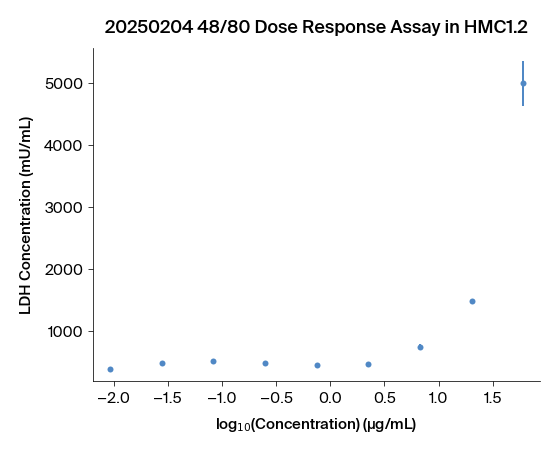

In [12]:
log_concentrations_ldh = np.log10(float_concentration_df_ldh.columns.astype(float))

means = float_concentration_df_ldh.mean()
std_devs = float_concentration_df_ldh.std()

plt.figure(figsize=(8, 6))
plt.errorbar(log_concentrations_ldh, means, yerr=std_devs, fmt="o", capsize=5, label="Data")

plt.xlabel(r"log$_{10}$(Concentration) (µg/mL)")
plt.ylabel("LDH Concentration (mU/mL)")
plt.title(experiment_name)

plt.savefig(labeled_datafile_ldh[:-4] + "_doseresponse.png", transparent=False)
plt.show()

In [13]:
x_data_ldh = log_concentrations_ldh
y_data_ldh = float_concentration_df_ldh.mean().values

p0 = [min(y_data_ldh), max(y_data_ldh), np.median(x_data_ldh), 1]

params_ldh, _ = curve_fit(sigmoid, x_data_ldh, y_data_ldh, p0=p0)
LC50 = 10 ** params_ldh[2]

y_pred_ldh = sigmoid(x_data_ldh, *params_ldh)

ss_res = np.sum((y_data_ldh - y_pred_ldh) ** 2)
ss_tot = np.sum((y_data_ldh - np.mean(y_data_ldh)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print("Fitted Parameters:")
print(f"  Min: {params_ldh[0]:.2e}")
print(f"  Max: {params_ldh[1]:.2e}")
print(f"  LC50: {LC50:.3f} µg/mL")
print(f"  Slope: {params_ldh[3]:.3f}")
print("Goodness of Fit:")
print(f"  R²: {r_squared:.4f}")

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [14]:
x_fit_ldh = np.linspace(min(x_data_ldh), max(x_data_ldh), 100)
y_fit_ldh = sigmoid(x_fit_ldh, *params_ldh)

plt.figure(figsize=(8, 6))
plt.errorbar(
    x_data_ldh,
    y_data_ldh,
    yerr=float_concentration_df_ldh.std(),
    fmt="o",
    capsize=5,
    label="Data",
)
plt.plot(x_fit_ldh, y_fit_ldh, label="Logistic Fit", linestyle="--")

plt.xlabel(r"log$_{10}$(Concentration) (µg/mL)")
plt.ylabel("LDH Concentration (mU/mL)")
plt.title(experiment_name)
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.savefig(labeled_datafile_ldh[:-4] + "_doseresponse_curvefit.png", transparent=False)
plt.show()

NameError: name 'params_ldh' is not defined

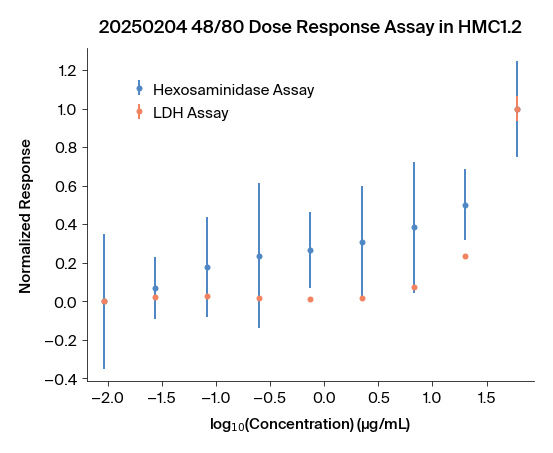

In [17]:
# Response values need to be normalized in order to plot them on the same graph.
# This will enable us to compare the response of each assay at a particular concentration.


def normalize_dataframe(df):
    y_values = df.mean().values
    min_val = np.min(y_values)
    max_val = np.max(y_values)
    return (df - min_val) / (max_val - min_val)


def normalize_fit(y_values):
    min_val = np.min(y_values)
    max_val = np.max(y_values)
    return (y_values - min_val) / (max_val - min_val)


hex_normalized = normalize_dataframe(float_concentration_df_hex)
ldh_normalized = normalize_dataframe(float_concentration_df_ldh)
"""
hex_fit_normalized = normalize_fit(sigmoid(x_fit_hex, *params_hex))
ldh_fit_normalized = normalize_fit(sigmoid(x_fit_ldh, *params_ldh))
"""
hex_normalized_mean = hex_normalized.mean().values
ldh_normalized_mean = ldh_normalized.mean().values

plt.figure(figsize=(8, 6))
plt.errorbar(
    x_data_hex,
    hex_normalized_mean,
    yerr=np.std(hex_normalized, axis=0),
    fmt="o",
    capsize=5,
    label="Hexosaminidase Assay",
)
plt.errorbar(
    x_data_ldh,
    ldh_normalized_mean,
    yerr=np.std(ldh_normalized, axis=0),
    fmt="o",
    capsize=5,
    label="LDH Assay",
)
"""
plt.plot(x_fit_hex, hex_fit_normalized, linestyle="--", label="Hexosaminidase Fit")
plt.plot(x_fit_ldh, ldh_fit_normalized, linestyle="--", label="LDH Fit")
"""
plt.xlabel(r"log$_{10}$(Concentration) (µg/mL)")
plt.ylabel("Normalized Response")
plt.title(experiment_name)
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.savefig(
    labeled_datafile_hex[:-4] + "_doseresponse_curvefit_superimposed.png",
    transparent=False,
)

plt.show()

In [16]:
import sys

loaded_modules = {
    name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
}
print(loaded_modules)

{'re': '2.2.1', 'ipaddress': '1.0', 'ipykernel._version': '6.29.4', 'json': '2.0.9', 'jupyter_client._version': '8.6.2', 'platform': '1.0.8', 'zmq.sugar.version': '26.0.3', 'zmq.sugar': '26.0.3', 'zmq': '26.0.3', 'logging': '0.5.1.2', 'traitlets._version': '5.14.3', 'traitlets': '5.14.3', 'jupyter_core.version': '5.7.2', 'jupyter_core': '5.7.2', 'zlib': '1.0', '_curses': b'2.2', 'socketserver': '0.4', 'argparse': '1.1', 'dateutil._version': '2.9.0.post0', 'dateutil': '2.9.0.post0', 'six': '1.16.0', '_decimal': '1.70', 'decimal': '1.70', 'platformdirs.version': '4.2.2', 'platformdirs': '4.2.2', '_csv': '1.0', 'csv': '1.0', 'jupyter_client': '8.6.2', 'ipykernel': '6.29.4', 'IPython.core.release': '8.26.0', 'executing.version': '2.0.1', 'executing': '2.0.1', 'pure_eval.version': '0.2.2', 'pure_eval': '0.2.2', 'stack_data.version': '0.6.3', 'stack_data': '0.6.3', 'pygments': '2.18.0', 'decorator': '5.1.1', 'wcwidth': '0.2.13', 'prompt_toolkit': '3.0.47', 'parso': '0.8.4', 'jedi': '0.19.1',

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_28136/3849240522.py:4: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.__version__.
  name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
